# Benchmark - Wind-dependent Variables: Predict Wind Speeds of Tropical Storms

<figure><center><img src="https://drivendata-public-assets.s3.amazonaws.com/re-hurricane-irma.jpg" width="500" height="40"></center></figure>

<p><center><i>Hurricane Irma Striking Miami, Florida. Credit: Warren Faidley, Getty Images</i></center></p>

Welcome to the benchmark solution tutorial for our brand new [competition](https://www.drivendata.org/competitions/72/predict-wind-speeds/) run in partnership with Radiant Earth Foundation and the [NASA Interagency Implementation and Advanced Concepts (IMPACT)](https://earthdata.nasa.gov/esds/impact) team.

In this challenge, you are tasked with estimating the wind speeds of tropical storms at different points in time using satellite images captured throughout a storm's life cycle. Because storm damage models rely on wind speed to approximate risk, accurate estimates can directly improve short-term storm intensity forecasting. Your machine learning models and insights have the potential to meaningfully strengthen disaster preparedness efforts around the world.

The training data for this competition consist of over 70,000 single-band images from storms in the Atlantic and East Pacific Oceans. The data come from a satellite band representing long-wave infrared frequency, which increases the brightness of clouds and should help us to better capture the spatial structure of storms. Each image has a corresponding wind speed contained in a separate file, measured in knots. For each image in the test set, you will predict the corresponding wind speed and will submit your predictions based on the `submission_format.csv` provided.

**In this post, we will show you how to load, explore, and prepare the data, as well as implement a first-pass deep learning model for predicting wind speeds.**

Let's get started!

## Explore the Data

### Metadata

To better understand what's in our data, we can begin by exploring trends across oceans, storms, wind speeds, and relative time using the training metadata.

Let's load the metadata and look at what we have.

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option("max_colwidth", 80)

<IPython.core.display.Javascript object>

In [3]:
# This is where our downloaded images and metadata live locally
DATA_PATH = Path.cwd().parent / "data" / "final" / "public"

<IPython.core.display.Javascript object>

In [4]:
train_metadata = pd.read_csv(DATA_PATH / "training_set_features.csv")
train_labels = pd.read_csv(DATA_PATH / "training_set_labels.csv")

<IPython.core.display.Javascript object>

In [5]:
train_metadata.head()

,image_id,storm_id,relative_time,ocean
0,abs_000,abs,0,2
1,abs_001,abs,1800,2
2,abs_002,abs,5400,2
3,abs_003,abs,17999,2
4,abs_004,abs,19799,2


<IPython.core.display.Javascript object>

In [6]:
train_metadata.shape

(70257, 4)

<IPython.core.display.Javascript object>

The training data consist of images identified by a unique `image_id`. Each `image_id` is composed of `{storm_id}_{image_number}`, where `storm_id` is a unique three letter code and `image_number` represents the sequential ordering of images throughout that storm.

Let's take a look at how many storms are in the training data, and how many images we have per storm.

In [7]:
train_metadata.storm_id.nunique()

494

<IPython.core.display.Javascript object>

In [8]:
storm_counts = train_metadata.groupby("storm_id").size()
storm_counts.describe()

count    494.000000
mean     142.220648
std      123.151772
min        4.000000
25%       46.250000
50%      101.500000
75%      209.000000
max      648.000000
dtype: float64

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Number of Images per Storm')

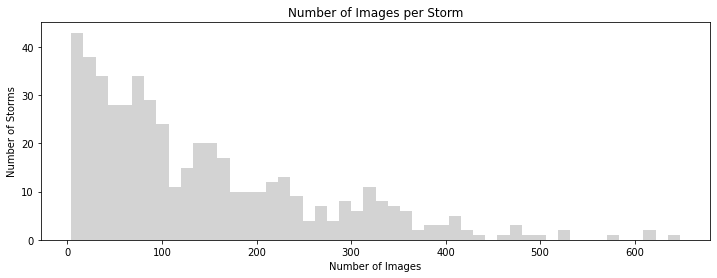

<IPython.core.display.Javascript object>

In [9]:
plt.figure(figsize=(12, 4))
plt.hist(storm_counts, bins=50, color="lightgray")
plt.xlabel("Number of Images")
plt.ylabel("Number of Storms")
plt.title("Number of Images per Storm")

The training data contain images from 494 storms. We have anywhere from 4 to 648 images per unique storm, with many storms containing fewer than 100 images.

We can also take a look at how many storms come from each ocean.

In [10]:
train_metadata.groupby("ocean")["storm_id"].nunique()

ocean
1    264
2    230
Name: storm_id, dtype: int64

<IPython.core.display.Javascript object>

Next, let's explore the overall distribution of wind speeds in the training data by looking at `train_labels`.

In [11]:
train_labels.head()

,image_id,wind_speed
0,abs_000,43
1,abs_001,44
2,abs_002,45
3,abs_003,52
4,abs_004,53


<IPython.core.display.Javascript object>

In [12]:
train_labels.describe()

,wind_speed
count,70257.000000
mean,50.344008
std,26.795277
min,15.000000
25%,30.000000
50%,43.000000
75%,62.000000
max,185.000000


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Distribution of Wind Speeds')

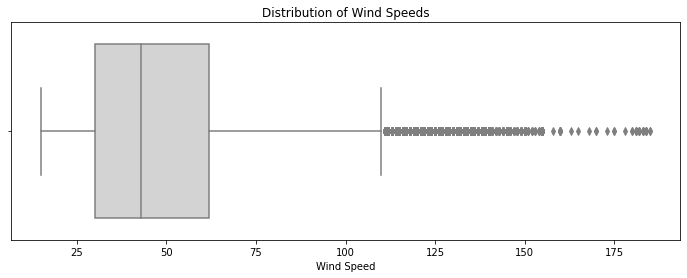

<IPython.core.display.Javascript object>

In [13]:
plt.figure(figsize=(12, 4))
sns.boxplot(x=train_labels.wind_speed, color="lightgray")
plt.xlabel("Wind Speed")
plt.title("Distribution of Wind Speeds")

Wind speeds in the training data range from 15 to 185 knots. A majority of images fall between 30 and 62 knots, but given what we know about storm intensity, it is especially important that we be able to accurately estimate the highest wind speeds.

Given the temporal nature of storm and wind patterns, relative time will be an important correlate of wind speed. Our metadata contains a relative time field measured in seconds since the beginning of a storm. We can merge `train_metadata` with `train_labels` to see how wind speeds change over the course of a storm for a couple of examples.

**Note: Don't forget that the goal of this competition is to produce an operational model that uses recent images to estimate future wind speeds. Your models may take advantage of the temporal data provided for each storm, up to the point of prediction. It may not use any information from images captured later in a storm to estimate the wind speeds of images captured earlier in a storm.**

In [14]:
# Merge train_metadata with train_labels on the image_id field
full_metadata = train_metadata.merge(train_labels, on="image_id")

<IPython.core.display.Javascript object>

In [15]:
def plot_wind_speeds(storm_id):
    storm = full_metadata[full_metadata.storm_id == storm_id]
    plt.figure(figsize=(12, 4))
    plt.scatter("relative_time", "wind_speed", data=storm, color="lightgray")
    plt.ticklabel_format(useOffset=False)
    plt.ylabel("Wind Speed")
    plt.title(f"Wind Speed over Relative Time: Storm {storm_id}")

<IPython.core.display.Javascript object>

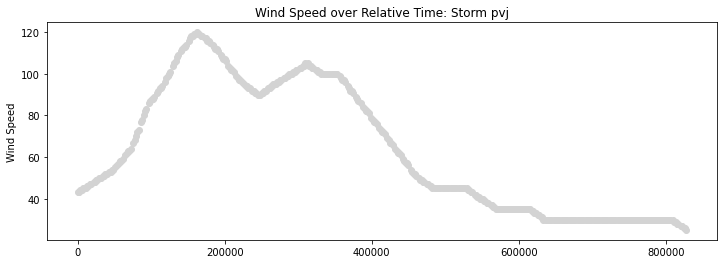

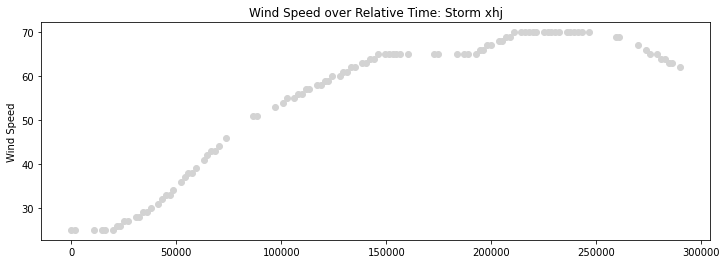

<IPython.core.display.Javascript object>

In [16]:
# Sample two random storms from full_metadata
for storm in full_metadata.storm_id.sample(2, random_state=40):
    plot_wind_speeds(storm)

For storm `pvj`, wind speeds begin around 40 knots, steadily increase to 120 knots, and then drop off again. Storm `xhj` displays a similar pattern, except that wind speeds hover around 70 knots before dropping off. While there appear to be short periods of time for which we do not have images available for these two storms, there is a clear relationship between relative time and wind speed that should be incorporated into our model. 

Keep in mind that the test set contains storms not represented in the training set, so our model needs to be able to generalize to storms it hasn't seen before. For storms represented in both the training and test sets, the test set images always temporally succeed the training set images.

### Images

Next, we can begin exploring the image data. We'll add a `file_name` column to our training metadata, which will contain a `Path` object with the full path to our data.

In [17]:
# Path style access for pandas
import pandas_path

<IPython.core.display.Javascript object>

In [18]:
full_metadata["file_name"] = (
    DATA_PATH / "train" / full_metadata.image_id.path.with_suffix(".jpg")
)

<IPython.core.display.Javascript object>

Now we can take a look at some of the storm imagery!  

Remember that because the data are single-band infrared images captured by Geostationary Operational Environmental Satellites (GOES), pixel values represent heat energy in the infrared spectrum. Data for this competition come from band #13. We will be able to see objects, like weather clouds, based on their temperatures, but these representations are actually invisible to the human eye.

In [19]:
from IPython.display import Image

<IPython.core.display.Javascript object>

In [20]:
def look_at_wind_speed(wind_speed):
    sample_img = full_metadata[full_metadata.wind_speed == wind_speed].file_name.iloc[0]
    return Image(str(sample_img))

<IPython.core.display.Javascript object>

What does a relatively low wind speed image look like?

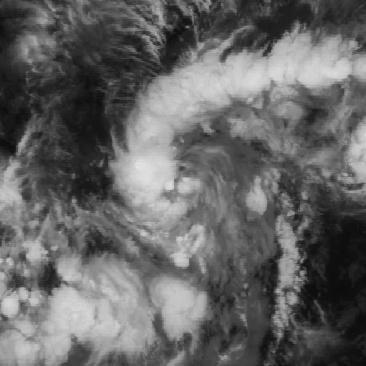

<IPython.core.display.Javascript object>

In [21]:
look_at_wind_speed(wind_speed=30)

How about a relatively high wind speed image?

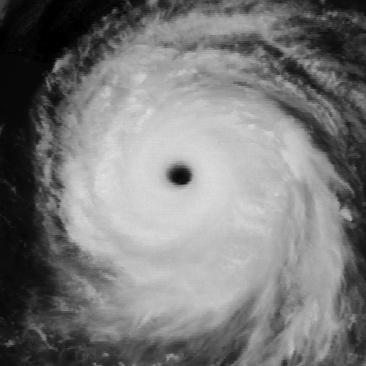

<IPython.core.display.Javascript object>

In [22]:
look_at_wind_speed(wind_speed=150)

Interesting! How about the image with the *highest* wind speed?

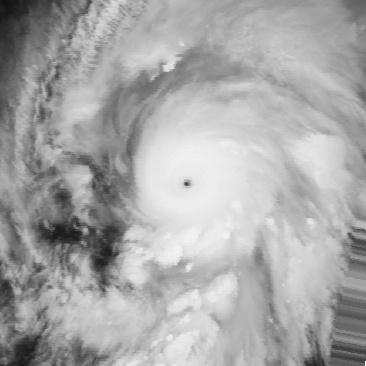

<IPython.core.display.Javascript object>

In [23]:
look_at_wind_speed(wind_speed=185)

With each increase in wind speed, we can see noticeable changes in storm structure and intensity. An effective model will be able to detect these types of patterns at scale.

Finally, let's confirm that the first few training images are the expected size of 366 x 366 pixels using [Pillow](https://pypi.org/project/Pillow/), imported as `PIL`.

In [24]:
from PIL import Image as pil_image

<IPython.core.display.Javascript object>

In [25]:
examples = [
    pil_image.open(full_metadata.iloc[i]["file_name"]).convert("RGB") for i in range(5)
]
for image in examples:
    print(image.size)

(366, 366)
(366, 366)
(366, 366)
(366, 366)
(366, 366)


<IPython.core.display.Javascript object>

## Split the Data

The test set for this competition includes a set of storms not included in the training data, as well as unseen imagery from later in a training storm's life cycle. We do not want to overstate our model's performance by overfitting to one or more storms. To be sure that our method is sufficiently generalizable, we will set aside a portion of the training imagery to validate the model during its development.

Since observations in a time series are not independent, we cannot randomly subset the training data into training and validation sets. In other words, the characteristics of temporal data, such as trends and seasonality, require that we take time into account when splitting the data. From a real-world perspective, it will always be the case that we will use images and wind measurements taken earlier in a storm to estimate wind speeds when new imagery comes in.

To account for the temporal relationship of the data up to the point of prediction and to ensure that we are not using images captured later in a storm to estimate prior wind speeds, we will subset the training data into training and validation sets using the `relative_time` field. For the purposes of this benchmark, we will holdout the last 20% of each storm's available images for our validation set.

You are encouraged to further incorporate relative time into your own model and should consider the implications of autocorrelation when determining how best to split the data.

In [26]:
# Add a temporary column for number of images per storm
images_per_storm = full_metadata.groupby("storm_id").size().to_frame("images_per_storm")
full_metadata = full_metadata.merge(images_per_storm, how="left", on="storm_id")

<IPython.core.display.Javascript object>

In [27]:
# Each storm is sorted by relative time
# Identify the final 20% of images per storm
full_metadata["pct_of_storm"] = (
    full_metadata.groupby("storm_id").cumcount() / full_metadata.images_per_storm
)
train = full_metadata[full_metadata.pct_of_storm < 0.8].drop(
    ["images_per_storm", "pct_of_storm"], axis=1
)
val = full_metadata[full_metadata.pct_of_storm >= 0.8].drop(
    ["images_per_storm", "pct_of_storm"], axis=1
)

<IPython.core.display.Javascript object>

In [28]:
# Confirm pct of images in the validation set is approximately 20%
len(val) / len(full_metadata) * 100

19.734688358455386

<IPython.core.display.Javascript object>

For the purposes of this benchmark, we will use a randomly selected subset of 10% of our available data for training and validation. This adjustment will increase performance as we build our initial pipeline, but can be adjusted back for final training.

In [29]:
# Sample 10% to increase performance
train = train.sample(frac=0.1, replace=False, random_state=1)
val = val.sample(frac=0.1, replace=False, random_state=1)

<IPython.core.display.Javascript object>

In [30]:
train.shape

(5639, 6)

<IPython.core.display.Javascript object>

In [31]:
val.shape

(1386, 6)

<IPython.core.display.Javascript object>

In [32]:
# Separate features from labels
x_train = train.drop("wind_speed", axis=1)
y_train = train.wind_speed

x_val = val.drop("wind_speed", axis=1)
y_val = val.wind_speed

<IPython.core.display.Javascript object>

## Build the Model

The goal of our first pass is to build a relatively simple model that outputs wind speed predictions given single-band infrared imagery as input. Once we test this basic approach, we can add additional elements of sophistication and complexity, such as hyperparameter tuning or sequence modeling. We will use a lightweight PyTorch wrapper called [PyTorch Lightning](https://pytorch-lightning.readthedocs.io/en/latest/) for this benchmark solution.

Rather than train an entire Convolutional Neural Network (CNN) from scratch, we will [fine-tune](https://cs231n.github.io/transfer-learning/) a pretrained model for transfer learning. This means that we will initialize our weights using a model that has been pretrained on a huge image dataset, replace and retrain its fully connected layer, and update the weights of the entire network by continuing backpropagation. There are many [pretrained models](https://pytorch.org/docs/stable/torchvision/models.html) to choose from. For this exercise, we will use a network called [ResNet 152](https://arxiv.org/abs/1512.03385), which was prepared by Microsoft Research Asia in 2015 for the Large Scale Visual Recognition Challenge and is pretrained on the ImageNet dataset.

First, we will need to read the training data into memory, convert the data to PyTorch tensors, and serve the data to our model in batches. Luckily, the PyTorch `Dataset` and `DataLoader` classes make implementing these complex tasks relatively straightforward. A `Dataset` object allows us to define custom methods for working with the data, and a `DataLoader` object parallelizes data loading. If you haven't worked with these classes before, we highly recommend this short [tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

Our custom dataset will inherit an abstract class called `torch.utils.data.Dataset` and [override](https://www.tutorialspoint.com/overriding-methods-in-python) the following methods:

- `__len__()`: returns the length of the dataset, measured as number of samples
- `__getitem__()`: provided an index, returns a sample from the dataset

The dataset object will return samples as dictionaries with keys for:

- `image_id`: the image id
- `image`: the image tensor
- `label`: the label, if it exists

Since `resnet152` was trained using images smaller than 366 x 366 pixels, we will use the `torchvision.transforms.Compose` module to downsize our images using center cropping, convert them to PyTorch tensors, and normalize their pixel values.

In [33]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms

<IPython.core.display.Javascript object>

In [34]:
class DatasetWIND(Dataset):
    """Reads in an image, transforms pixel values, and serves
    a dictionary containing the image id, image tensors, and label.
    """

    def __init__(self, x_train, y_train=None):
        self.data = x_train
        self.label = y_train
        self.transform = transforms.Compose(
            [
                transforms.CenterCrop(128),
                transforms.ToTensor(),
                # All models expect the same normalization mean & std
                # https://pytorch.org/docs/stable/torchvision/models.html
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                ),
            ]
        )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = pil_image.open(self.data.iloc[index]["file_name"]).convert("RGB")
        image = self.transform(image)
        image_id = self.data.iloc[index]["image_id"]
        if self.label is not None:
            label = self.label.iloc[index]
            sample = {"image_id": image_id, "image": image, "label": label}
        else:
            sample = {
                "image_id": image_id,
                "image": image,
            }
        return sample

<IPython.core.display.Javascript object>

Now that we have a way of processing the data, we can use `torch.utils.data.DataLoader` to serve the data within our model class (more on this later).

Next, we will create a custom class to define our loss function, Root Mean Square Error (RMSE). As a reminder, RMSE represents the square root of the mean of the squared differences between the predicted values and the actual values. This class will inherit `nn.Module`, which is the [base class](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) for all neural network modules in PyTorch. The `forward` method is built upon `MSELoss()`, which measures mean squared error.

In [35]:
from torch import nn

<IPython.core.display.Javascript object>

In [36]:
class RMSELoss(nn.Module):
    """Measures root mean square error."""

    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, pred, true):
        return torch.sqrt(self.mse(pred, true))

<IPython.core.display.Javascript object>

Given our new `DatasetWIND` and `RMSELoss` classes, PyTorch Lightning will allow us to train a model using minimal for loops. This library keeps the flexibility of PyTorch but removes most of the boilerplate training code, making it less error prone, cleaner to read, and easier to update. By subclassing  `pl.LightningModule`, most of the training logic will happen for us behind the scenes. If you're new to PyTorch Lightning, you may find their [quick start](https://pytorch-lightning.readthedocs.io/en/latest/new-project.html) guide helpful.

We will define the following methods within our model:

- `prepare_model`: import a pretrained model and reinitialize the final layer with a new sequence of modules
- `forward`: define the forward pass for an image
- `training_step` (required): switch the model to train mode, implement the forward pass, and calculate training loss for a batch
- `validation_step`: switch the model to eval mode and calculate validation loss for a batch
- `train_dataloader` (required): call an iterable over the training dataset for automatic batching
- `val_dataloader`: call an iterable over the validation dataset for automatic batching
- `configure_optimizers` (required): configure an [optimizer](https://pytorch.org/docs/stable/optim.html) (we will use Adam); this step automatically calls `backward` and `step` in each epoch
- `training_epoch_end`: calculate the average loss for an epoch with the outputs of `training_step`
- `validation_epoch_end`: calculate the average loss for an epoch with the outputs of `validation_step`

We'll also add a couple additional, optional, helper methods, e.g., `fit` to instantiate and fit a `pl.Trainer` object for training automation, and `make_submission_frame` to prepare our competition submission csv.

In [37]:
import warnings

import pytorch_lightning as pl
from torch.utils.data import DataLoader
import torchvision.models as models
from tqdm import tqdm

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [38]:
class PretrainedWindModel(pl.LightningModule):
    def __init__(self, hparams):
        super(PretrainedWindModel, self).__init__()
        self.hparams = hparams
        self.learning_rate = self.hparams.get("lr", 2e-4)
        self.hidden_size = self.hparams.get("embedding_dim", 50)
        self.dropout = self.hparams.get("dropout", 0.1)
        self.max_epochs = self.hparams.get("max_epochs", 1)
        self.num_workers = self.hparams.get("num_workers", 0)
        self.batch_size = self.hparams.get("batch_size", 10)
        self.x_train = self.hparams.get("x_train")
        self.y_train = self.hparams.get("y_train")
        self.x_val = self.hparams.get("x_val")
        self.y_val = self.hparams.get("y_val")
        self.num_outputs = 1  # One prediction for regression

        # Where final model will be saved
        self.output_path = Path.cwd() / self.hparams.get("output_path", "model-outputs")
        self.output_path.mkdir(exist_ok=True)

        # Where TensorBoard logs will be saved
        self.log_path = Path.cwd() / self.hparams.get("log_path", "logs")
        self.log_path.mkdir(exist_ok=True)
        self.logger = pl.loggers.TensorBoardLogger(
            self.log_path, name="benchmark_model"
        )

        # Instantiate training and validation datasets
        self.train_dataset = DatasetWIND(self.x_train, self.y_train)
        self.val_dataset = DatasetWIND(self.x_val, self.y_val)
        self.model = self.prepare_model()

    def prepare_model(self):
        res_model = models.resnet152(pretrained=True)
        # Input size of 2048 for resnet152
        # https://pytorch.org/hub/pytorch_vision_resnet/
        res_model.fc = nn.Sequential(
            nn.Linear(2048, self.hidden_size),
            nn.ReLU(inplace=True),
            nn.Dropout(self.dropout),
            nn.Linear(self.hidden_size, self.num_outputs),
        )
        return res_model

    def forward(self, image):
        return self.model(image)

    def training_step(self, batch, batch_idx):
        x = batch["image"]
        y = batch["label"]
        criterion = RMSELoss()
        # Switch to training mode
        loss = criterion(
            self.model.train().forward(x).squeeze(), y.type(torch.FloatTensor)
        )
        tensorboard_logs = {"train_loss": loss}
        return {"loss": loss, "log": tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        x = batch["image"]
        y = batch["label"]
        criterion = RMSELoss()
        # Switch to evaluation mode
        loss = criterion(
            self.model.eval().forward(x).squeeze(), y.type(torch.FloatTensor)
        )
        tensorboard_logs = {"val_loss": loss}
        return {"batch_val_loss": loss, "log": tensorboard_logs}

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, num_workers=self.num_workers, batch_size=self.batch_size
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset, num_workers=self.num_workers, batch_size=self.batch_size
        )

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=self.learning_rate)

    def training_epoch_end(self, outputs):
        avg_train_loss = torch.stack(tuple(output["loss"] for output in outputs)).mean()
        return {
            "avg_epoch_train_loss": avg_train_loss,
            "progress_bar": {"avg_epoch_train_loss": avg_train_loss},
            "log": {"avg_epoch_train_loss": avg_train_loss},
        }

    def validation_epoch_end(self, outputs):
        avg_val_loss = torch.stack(
            tuple(output["batch_val_loss"] for output in outputs)
        ).mean()
        return {
            "avg_epoch_val_loss": avg_val_loss,
            "progress_bar": {"avg_epoch_val_loss": avg_val_loss},
            "log": {"avg_epoch_val_loss": avg_val_loss},
        }

    ## Convenience Methods ##

    def fit(self):
        self.trainer = pl.Trainer(
            max_epochs=self.max_epochs,
            default_root_dir=self.output_path,
            logger=self.logger,
            checkpoint_callback=pl.callbacks.ModelCheckpoint(
                filepath=self.output_path,
                monitor="avg_epoch_val_loss",
                mode="min",
                verbose=True,
            ),
            gradient_clip_val=self.hparams.get("gradient_clip_val", 1),
            num_sanity_val_steps=self.hparams.get("val_sanity_checks", 0),
        )
        self.trainer.fit(self)

    @torch.no_grad()
    def make_submission_frame(self, x_test):
        test_dataset = DatasetWIND(x_test)
        test_dataloader = DataLoader(
            test_dataset, num_workers=self.num_workers, batch_size=self.batch_size
        )
        submission_frame = pd.DataFrame(index=x_test.image_id, columns=["wind_speed"])
        for batch in tqdm(test_dataloader, total=len(test_dataloader)):
            x = batch["image"]
            preds = self.eval().forward(x)
            submission_frame.loc[batch["image_id"], "wind_speed"] = (
                preds.detach().numpy().squeeze()
            )
        submission_frame.wind_speed = submission_frame.wind_speed.astype(float)
        return submission_frame

<IPython.core.display.Javascript object>

## Fit the Model

Finally, it's time to fit our model. A `PretrainedWindModel` can be instantiated using only a dictionary of `hparams`. The only required `hparams` are the training and validation data, but there are several additional hyperparameters we can specify to explore modeling strategies, including the learning rate, dropout rate, and hidden layer size. Consider experimenting with different models and using hyperparameter tuning to find the best combination of parameters to increase performance.

Once we specify our `hparams`, we can simply call the `fit` method to begin training!

In [39]:
hparams = {
    # Required hparams
    "x_train": x_train,
    "y_train": y_train,
    "x_val": x_val,
    "y_val": y_val,
    # Optional hparams
    "lr": 2e-4,
    "embedding_dim": 100,
    "dropout": 0.1,
    "max_epochs": 4,
    "batch_size": 10,
    "num_workers": 0,
    "gradient_clip_val": 1,
    "val_sanity_checks": 0,
    "output_path": "model-outputs",
    "log_path": "logs",
}

<IPython.core.display.Javascript object>

In [40]:
storm_model = PretrainedWindModel(hparams=hparams)
storm_model.fit()

Note: PyTorch Lightning lets you log PyTorch models and metrics into a directory for visualization within the [TensorBoard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) UI. TensorBoard is a machine learning visualization toolkit that's helpful for tracking metrics across batches, epochs, and models. You can install TensorBoard through the command line to visualize your logged data by specifying the root log directory and running `tensorboard --logdir=logs/benchmark_model`.

## Make a Submission

Now that our model is trained, we are finally ready to perform inference and make a submission. You'll only want to perform inference on the test set once you determine your top performing model, to avoid inadvertently overfitting.

First, let's take a look at the submission format. Make sure to that your submission sets `image_id` as the index to avoid getting a submission error.

In [41]:
submission_format = pd.read_csv(
    DATA_PATH / "submission_format.csv", index_col="image_id"
)
submission_format.head()

,wind_speed
image_id,
acd_123,0
acd_124,0
acd_125,0
acd_126,0
acd_127,0


<IPython.core.display.Javascript object>

PyTorch Lightning automatically saves everything you need to restore training sessions as [checkpoints](https://pytorch-lightning.readthedocs.io/en/latest/weights_loading.html) in your current working directory. We updated this directory using the `output_path` hyperparameter in `hparams`. Even though model training has the potential to get interrupted, you should always be able to pick back up where you left off without having to restart training from scratch.

Let's load our best model from the `model-outputs` directory.

In [42]:
# Best checkpoint based on logs
best_checkpoint = str(Path("model-outputs") / "epoch=3.ckpt")
example_model = PretrainedWindModel.load_from_checkpoint(best_checkpoint)

<IPython.core.display.Javascript object>

Finally, we can estimate wind speeds in the test set!

In [43]:
test_metadata = pd.read_csv(DATA_PATH / "test_set_features.csv")
test_metadata["file_name"] = (
    DATA_PATH / "test" / test_metadata.image_id.path.with_suffix(".jpg")
)

<IPython.core.display.Javascript object>

In [44]:
submission = example_model.make_submission_frame(test_metadata)

In [45]:
# Ensure submission indices match submission format
assert submission_format.index.equals(submission.index)

<IPython.core.display.Javascript object>

In [46]:
submission.head()

,wind_speed
image_id,
acd_123,28.469728
acd_124,27.609617
acd_125,27.415846
acd_126,27.957870
acd_127,28.268888


<IPython.core.display.Javascript object>

The first few predictions look reasonable, based on our training data exploration. However, `wind_speed` must be an integer based on the `submission_format`, so let's round our final predictions to the nearest integer.

In [47]:
submission = submission.round().astype(int)
submission.head()

,wind_speed
image_id,
acd_123,28
acd_124,28
acd_125,27
acd_126,28
acd_127,28


<IPython.core.display.Javascript object>

Let's take a look at the range of wind speeds that we are estimating in the test set.

In [48]:
submission.wind_speed.describe()

count    44377.000000
mean        43.189310
std         19.000623
min         24.000000
25%         31.000000
50%         37.000000
75%         48.000000
max        153.000000
Name: wind_speed, dtype: float64

<IPython.core.display.Javascript object>

A minimum wind speed of 24 knots and a maximum wind speed of 153 knots seems like a reasonable range.

Finally, we will save our submission locally.

In [49]:
submission.to_csv((DATA_PATH / "submission.csv"), index=True)

<IPython.core.display.Javascript object>

We can now head to the competition [submissions page](https://www.drivendata.org/competitions/72/predict-wind-speeds/submissions/) and upload our submission to obtain our model's RMSE.

<img src="https://drivendata-public-assets.s3.amazonaws.com/re-benchmark-score.png" width="700" height="60">

We should see an RMSE of 12.6912 on the leaderboard. That's a great start, but now it's up to you to make improvements and lower this error! We hope this benchmark solution provides a helpful framework for exploring the data, designing a machine learning pipeline, and training a deep learning model to predict the wind speeds associated with storm imagery for disaster preparedness.

Head over to the [Wind-dependent Variables](https://www.drivendata.org/competitions/72/predict-wind-speeds/) challenge homepage to get started. We can't wait to see what you build!